In [2]:
import os

import nflows
import torch
import numpy as np

from model import model_MAF
from model.modules import data_preprocessing
from model.modules import dataset_supercell as dataset
from model.modules import loader
from model.modules import utils
from model.modules import visualizations

import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as tick
from matplotlib import cm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['lines.linewidth']=6
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

ModuleNotFoundError: No module named 'nflows'

In [2]:
supercells = ['/bigdata/hplsim/aipp/Anna/lwfa_10cells/'+nextfile for nextfile in os.listdir('/bigdata/hplsim/aipp/Anna/lwfa_10cells') if 'models' not in nextfile]
supercells_tensors = []
for ind in range(len(supercells)):
    supercells_tensors.append(np.loadtxt(supercells[ind]))
all_cells = np.concatenate([arr for arr in supercells_tensors], axis=0)
print(all_cells.shape)
np.savetxt('/bigdata/hplsim/aipp/Anna/lwfa_merged/1728supercells.npy', all_cells)

(848499, 6)


In [3]:
#path_to_particle_data = '/bigdata/hplsim/aipp/Anna/lwfa_tests/10700_44_1151_51.npy'
path_to_particle_data = '/bigdata/hplsim/aipp/Anna/lwfa_merged/1728supercells.npy'
dataset_tr = dataset.PCDataset(item_phase_space=path_to_particle_data,
                               normalize=True, a=0., b=1.)
model_f = model_MAF.PC_MAF(dim_condition=2,
                           dim_input=6,
                           num_coupling_layers=3,
                           hidden_size=64,
                           device='cuda',
                           enable_wandb=False)
param_size = 0
for param in model_f.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_f.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

state = {
            'model': model_f.state_dict(),
            'vmin_ps': model_f.vmin_ps,
            'vmax_ps': model_f.vmax_ps,
            'vmin_rad': model_f.vmin_rad,
            'vmax_rad': model_f.vmax_rad,
            'a': model_f.a,
            'b': model_f.b
            }

torch.save(state, './model.pt')

model size: 0.420MB


In [4]:
optimizer = torch.optim.Adam(model_f.model.parameters(), lr=1e-3,
                             betas=(0.8, 0.9), eps=1e-6, weight_decay=2e-5)
#test_pointcloud = "/bigdata/hplsim/aipp/Anna/lwfa_supercells/10700_40_1123_101.npy"
test_pointcloud = path_to_particle_data
test_radiation = "/home/willma32/insitu_particles/InSituML/main/ModelHelpers/cINN/rad_test.npy"

log_plots = visualizations.log_one_plot

In [5]:
model_f.train_(dataset_tr,
               dataset_tr,
               optimizer,
               epochs=1001,
               batch_size=10000,
               test_epoch=100,
               test_pointcloud=test_pointcloud, test_radiation=test_radiation, log_plots=log_plots,
               path_to_models=None)

Total number of points:  848499
Size of loader:  85
epoch : 1/1001,
	loss_avg = 0.683889853550286
epoch : 101/1001,
	loss_avg = -7.156547972735237
epoch : 201/1001,
	loss_avg = -7.537939986060647


KeyboardInterrupt: 

In [23]:
param_size = 0
for param in model_f.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_f.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

state = {
            'model': model_f.state_dict(),
            'vmin_ps': model_f.vmin_ps,
            'vmax_ps': model_f.vmax_ps,
            'vmin_rad': model_f.vmin_rad,
            'vmax_rad': model_f.vmax_rad,
            'a': model_f.a,
            'b': model_f.b
            }

torch.save(state, './model.pt')

model size: 0.420MB


In [6]:
supercell = [int(k) for k in test_pointcloud.split('/')[-1].split('.')[0].split('_')[1:]]
iteration = test_pointcloud.split('/')[-1].split('.')[0].split('_')[0]
pointcloud_tensor = np.loadtxt(test_pointcloud)

num_particles = 10000
idx = np.random.randint(pointcloud_tensor.shape[0], size=num_particles)
pointcloud_tensor = pointcloud_tensor[idx, :]
radiation_tensor = torch.Tensor([0.5,0.5]).float().repeat(pointcloud_tensor.shape[0], 1)

labels_x = ['x', 'y', 'z']
labels_y = ['xp', 'yp', 'zp']

pred_pointcloud_full = model_f.sample_pointcloud(radiation_tensor.to(model_f.device), radiation_tensor.shape[0])
pred_pointcloud = pred_pointcloud_full.detach().cpu().numpy()

Text(0.5, 0.98, 'Reconstruction')

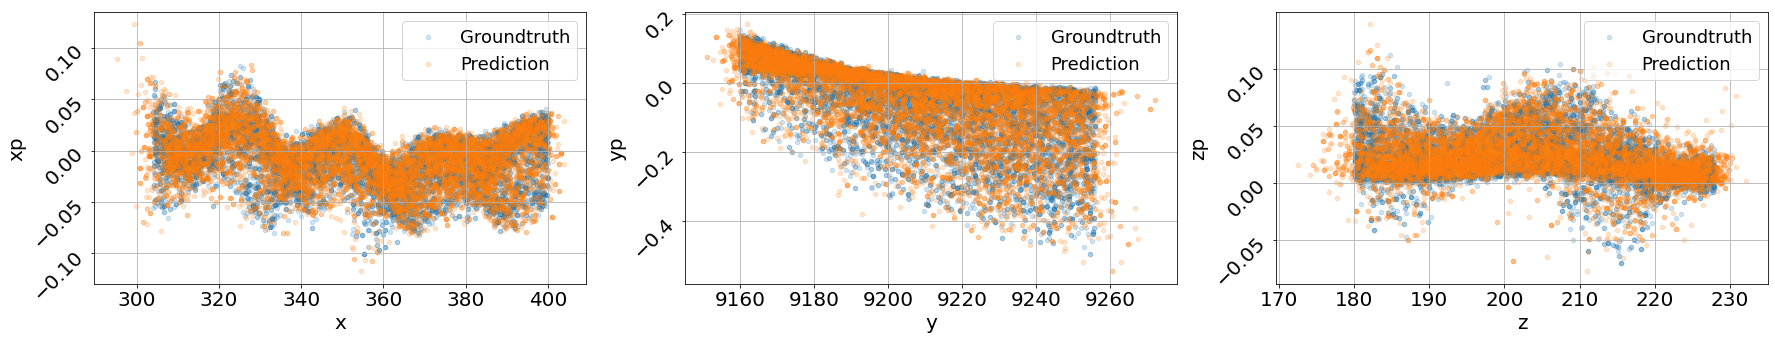

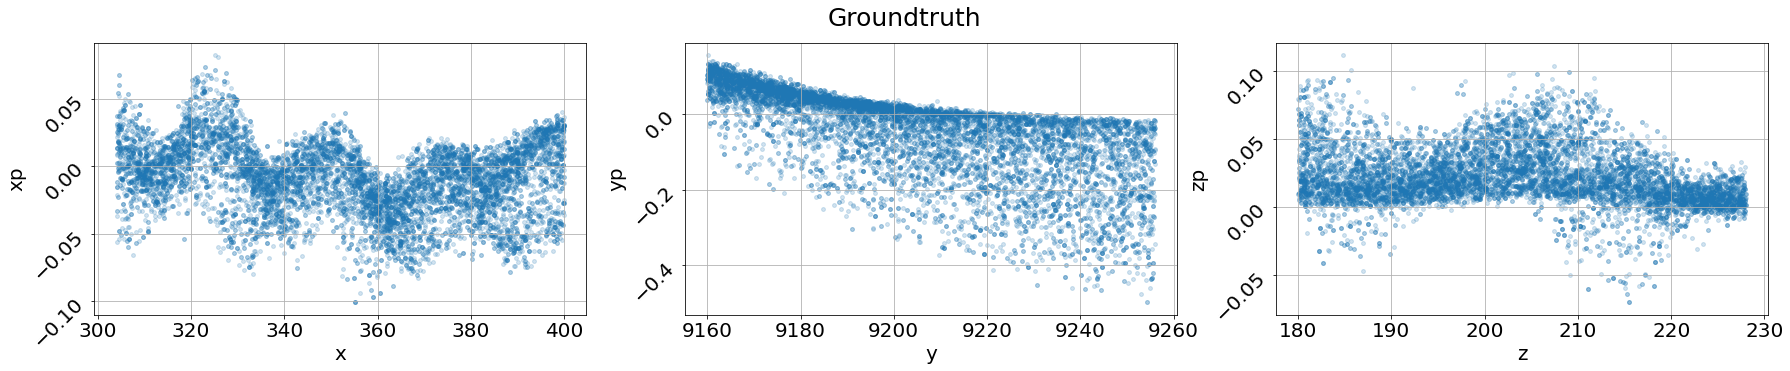

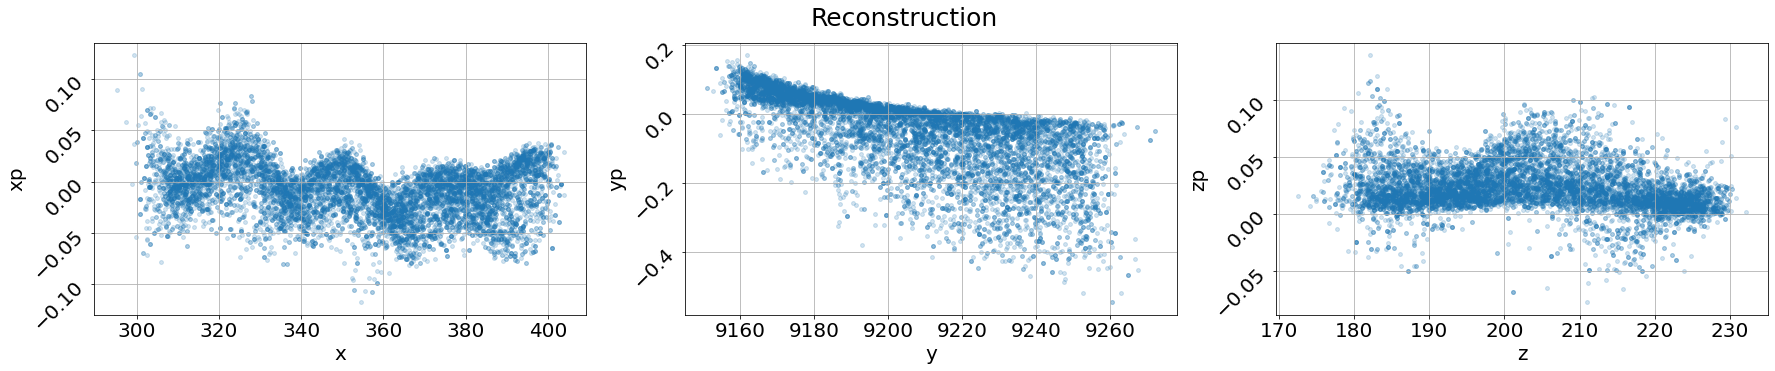

In [10]:
def plot_2D_GTandRec(pc, pc_pred, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=20, alpha=0.2, label='Groundtruth')
    if pc_pred is not None:
        axs.scatter(pc_pred[:,comp_x], pc_pred[:,comp_y], s=20, alpha=0.2, label='Prediction')
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)
    axs.legend(fontsize=18, loc='upper right')
    
def plot_2D(pc, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=15, alpha=0.2)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
num_particles = 10000
idx = np.random.randint(pointcloud_tensor.shape[0], size=num_particles)

for i in range(3):
    plot_2D_GTandRec(pointcloud_tensor[idx, :], pred_pointcloud[idx, :],
                     comp_x=i, comp_y=i+3, axs=axs[i],
                     label_x=labels_x[i], label_y=labels_y[i])

    
figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_2D(pointcloud_tensor[idx, :], comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])
fig.suptitle('Groundtruth', fontsize=25)

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))
for i in range(3):
    plot_2D(pred_pointcloud[idx, :], comp_x=i, comp_y=i+3, axs=axs[i], label_x=labels_x[i], label_y=labels_y[i])
fig.suptitle('Reconstruction', fontsize=25)

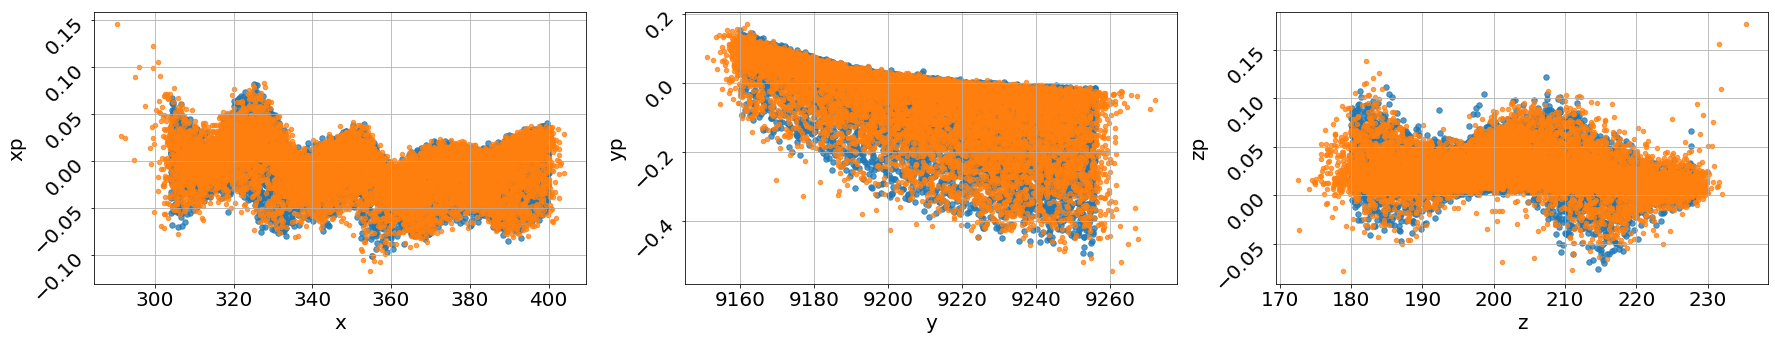

In [7]:
def plot_2D_GTandRec(pc, pc_pred, comp_x, comp_y, axs, label_x, label_y):
    axs.scatter(pc[:,comp_x], pc[:,comp_y], s=30, alpha=0.75)
    if pc_pred is not None:
        axs.scatter(pc_pred[:,comp_x], pc_pred[:,comp_y], s=20, alpha=0.75)
    axs.tick_params(axis='y', which='major', rotation=45)
    axs.grid(True)
    axs.set_xlabel(label_x)
    axs.set_ylabel(label_y)

figsize1 = 30
figsize2 = 5
fig, axs = plt.subplots(1, 3, figsize=(figsize1,figsize2))

for i in range(3):
    plot_2D_GTandRec(pointcloud_tensor, pred_pointcloud,
                     comp_x=i, comp_y=i+3, axs=axs[i],
                     label_x=labels_x[i], label_y=labels_y[i])

In [26]:
def plot_per_slice(pc, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        #std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]
        axs.plot([slice_ for slice_ in slices], mean_energy)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

def plot_per_slice_GTandRec(pc, pc_pred, slice_along, num_slices, comp_of_interest, axs, label='Number of particles'):
    if pc_pred is not None:
        slices_pred = [np.min(pc_pred[:, slice_along]) + (np.max(pc_pred[:, slice_along]) - np.min(pc_pred[:, slice_along])) * i/num_slices for i in range(num_slices)]
        pc_pred_ = np.concatenate((pc_pred, np.zeros((pc_pred.shape[0], 1))), axis=1)

        for ind in range(len(slices_pred)-1):
            pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[ind]) & (pc_pred_[:, -3]<=slices_pred[ind+1])] = ind
        pc_pred_[:, -1][(pc_pred_[:, -3]>=slices_pred[-1])] = len(slices_pred) - 1
    
    if comp_of_interest is not None:
        comp_of_interest = comp_of_interest - 1

    slices = [np.min(pc[:, slice_along]) + (np.max(pc[:, slice_along]) - np.min(pc[:, slice_along])) * i/num_slices for i in range(num_slices)]
    pc_ = np.concatenate((pc, np.zeros((pc.shape[0], 1))), axis=1)

    for ind in range(len(slices)-1):
        pc_[:, -1][(pc_[:, slice_along]>=slices[ind]) & (pc_[:, slice_along]<=slices[ind+1])] = ind
    pc_[:, -1][(pc_[:, slice_along]>=slices[-1])] = len(slices) - 1

    if comp_of_interest is not None:
        mean_energy = [np.mean(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if (pc_[:, comp_of_interest][pc_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices))]
        std_energy = [np.std(pc_[:, comp_of_interest][pc_[:,-1]==ind]) if pc_[:, comp_of_interest][pc_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices)) ]

        #axs.plot([slice_ for slice_ in slices], mean_energy, label="Groundtruth")
        if pc_pred is not None:
            print('plot pred', slices_pred)
            mean_energy_pred = [np.mean(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if (pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]).shape[0] > 1 else None for ind in range(len(slices_pred))]
            std_energy_pred = [np.std(pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind]) if pc_pred_[:, comp_of_interest+1][pc_pred_[:,-1]==ind].shape[0] > 1 else None for ind in range(len(slices_pred)) ]
            axs.plot([slice_ for slice_ in slices_pred], mean_energy_pred, label="Reconstruction")
            
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        axs.legend(prop={'size': 20})


    if comp_of_interest == None:
        num_particles = [pc_[pc_[:,-1]==ind].shape[0] for ind in range(len(slices))]
        axs.plot([slice_ for slice_ in slices], num_particles)
        if pc_pred is not None:
            num_particles_pred = [pc_pred_[pc_pred_[:,-1]==ind].shape[0] for ind in range(len(slices_pred))]
            axs.plot([slice_ for slice_ in slices_pred], num_particles_pred)
        axs.tick_params(axis='y', which='major', rotation=45)
        axs.grid(True)
        axs.set_xlabel('Z')
        axs.set_ylabel(label)
        #axs.legend(prop={'size': 20})

plot pred [202.56365966796875, 202.63222579956056, 202.70079193115234, 202.76935806274415, 202.83792419433593, 202.90649032592773, 202.97505645751954, 203.04362258911132, 203.11218872070313, 203.1807548522949, 203.24932098388672, 203.31788711547853, 203.3864532470703, 203.45501937866212, 203.5235855102539, 203.5921516418457, 203.6607177734375, 203.7292839050293, 203.7978500366211, 203.86641616821288, 203.9349822998047, 204.0035484313965, 204.07211456298828, 204.14068069458008, 204.20924682617186, 204.27781295776367, 204.34637908935548, 204.41494522094726, 204.48351135253907, 204.55207748413085, 204.62064361572266, 204.68920974731446, 204.75777587890624, 204.82634201049805, 204.89490814208983, 204.96347427368164, 205.03204040527345, 205.10060653686523, 205.16917266845704, 205.23773880004882, 205.30630493164062, 205.37487106323243, 205.4434371948242, 205.51200332641602, 205.5805694580078, 205.6491355895996, 205.71770172119142, 205.7862678527832, 205.854833984375, 205.92340011596679, 205.

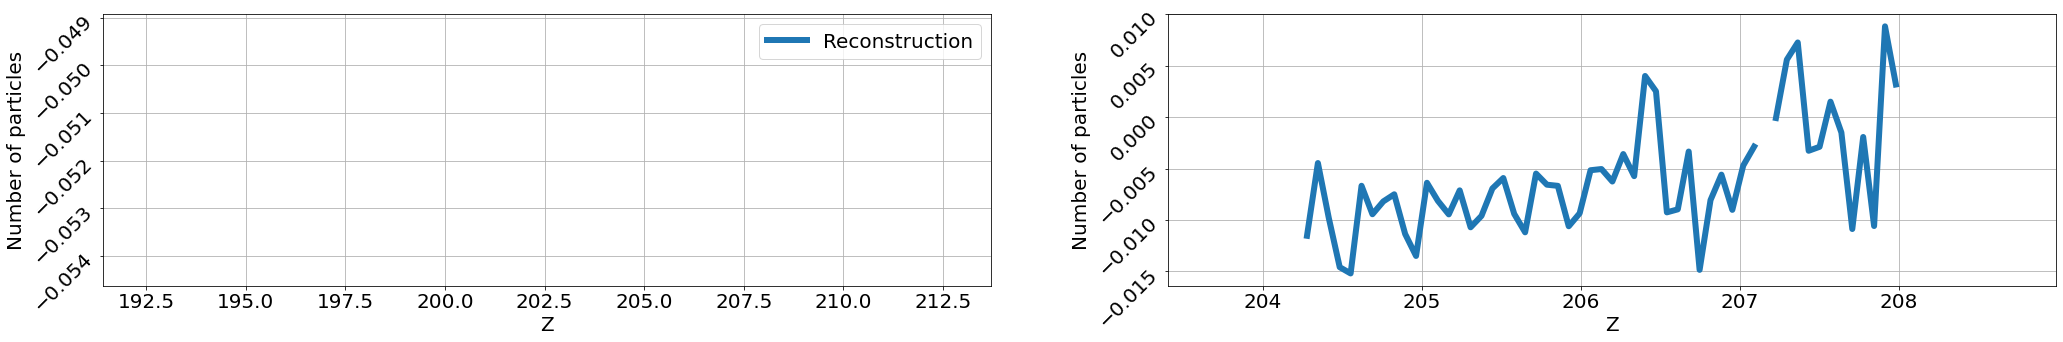

In [27]:
slice_along = 2 #z: 2
num_slices = 100
comp_of_interest = -3
figsize1 = 35
figsize2 = 5

fig, axs = plt.subplots(1, 2, figsize=(figsize1,figsize2))
plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
                        slice_along, num_slices, comp_of_interest,
                        axs[0], label='Number of particles')

plot_per_slice(pred_pointcloud, slice_along, num_slices, comp_of_interest, axs[1], label='Number of particles')

#for i in range(1,4,1):
#    visualizations.plot_per_slice_GTandRec(pointcloud_tensor, pred_pointcloud,
#                        slice_along, num_slices, comp_of_interest=-1*i,
#                        axs=axs[i], label='Mean ' + labels_y[-1*i])